In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
import sqlite3



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df_athletes= pd.read_excel('/content/gdrive/My Drive/2021olympic/Athletes.xlsx')
df_entriesgender= pd.read_excel('/content/gdrive/My Drive/2021olympic/EntriesGender.xlsx')
df_teams= pd.read_excel('/content/gdrive/My Drive/2021olympic/Teams.xlsx')
df_coaches= pd.read_excel('/content/gdrive/My Drive/2021olympic/Coaches.xlsx')
df_medals= pd.read_excel('/content/gdrive/My Drive/2021olympic/Medals.xlsx')

In [ ]:
df_entriesgender_SQL = df_entriesgender

df_teams_SQL = df_teams 

df_athletes_SQL = df_athletes 

df_coaches_SQL = df_coaches 

df_medals_SQL = df_medals.rename(columns = {'Team/NOC': 'Teamnoc',
                              }, inplace = False)

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

df_entriesgender_SQL.to_sql("EntriesGender", con =engine)
df_teams_SQL.to_sql("Teams", con =engine)
df_athletes_SQL.to_sql("Athletes", con =engine)
df_coaches_SQL.to_sql("Coaches", con =engine)
df_medals_SQL.to_sql("Medals", con =engine)

In [ ]:
sql='''

Select * from entriesgender

''';

    
df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,index,Discipline,Female,Male,Total
0,0,3x3 Basketball,32,32,64
1,1,Archery,64,64,128
2,2,Artistic Gymnastics,98,98,196
3,3,Artistic Swimming,105,0,105
4,4,Athletics,969,1072,2041


# Get the total count of participants for each discipline

In [ ]:
sql = '''
Select discipline, total as participants
from entriesgender
group by discipline
order by participants desc
LIMIT 20
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,Discipline,participants
0,Athletics,2041
1,Swimming,779
2,Football,608
3,Rowing,522
4,Judo,393


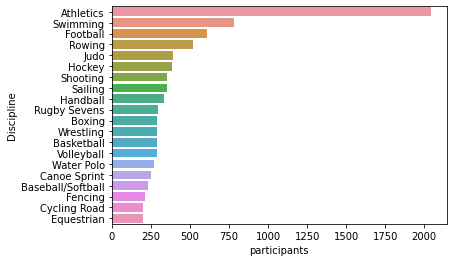

In [ ]:
sns.barplot(y = 'Discipline', x = 'participants', data = df_sql)

# get top 5 countries with most medals

In [ ]:
sql = '''
Select *
From medals
order by total desc
LIMIT  5
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,index,Rank,Teamnoc,Gold,Silver,Bronze,Total,Rank by Total
0,0,1,United States of America,39,41,33,113,1
1,1,2,People's Republic of China,38,32,18,88,2
2,4,5,ROC,20,28,23,71,3
3,3,4,Great Britain,22,21,22,65,4
4,2,3,Japan,27,14,17,58,5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/i

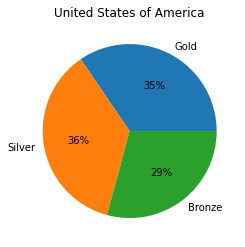

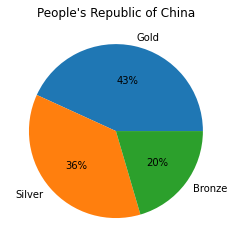

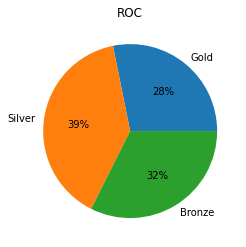

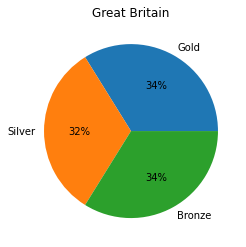

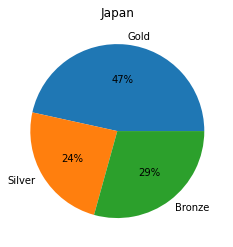

In [ ]:
for i in range(5):
  plt.figure(i)
  plt.pie(x = [df_sql[i:i+1][['Gold']],df_sql[i:i+1][['Silver']],df_sql[i:i+1][['Bronze']]] ,labels = ['Gold','Silver','Bronze'],autopct='%.0f%%')
  str(df_sql[i:i+1][['Teamnoc']])
  plt.title(df_sql.loc[df_sql['Rank by Total'] == i+1, 'Teamnoc'].item())
plt.show()

# Get the number of athletes for each country, in descending order

In [ ]:
sql = '''
Select *
From (Select NOC, Count(name) as number_athletes 
      from athletes
      group by NOC
      order by number_athletes DESC )
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,NOC,number_athletes
0,United States of America,615
1,Japan,586
2,Australia,470
3,People's Republic of China,401
4,Germany,400


# Number of Coaches per country 

In [ ]:
sql = '''
Select Count(Name) as number_coaches, NOC
From coaches
group by NOC
Order by number_coaches DESC
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,number_coaches,NOC
0,35,Japan
1,28,Spain
2,28,United States of America
3,22,Australia
4,16,Canada


# Coach vs Player Ratio using *CTE*

In [ ]:
sql = '''
WITH coach as (SELECT Count(Name) as number_coaches, NOC
From coaches
group by NOC
Order by number_coaches DESC
), 
ath as (SELECT Count(Name) as number_athletes, NOC
From athletes
group by NOC
Order by number_athletes DESC)
SELECT c.NOC, a.number_athletes, c.number_coaches,  (a.number_athletes/c.number_coaches) as player_coach_ratio
FROM coach as c
inner join ath as a 
on c.NOC = a.NOC
order by player_coach_ratio DESC

''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,NOC,number_athletes,number_coaches,player_coach_ratio
0,Belarus,104,1,104
1,Turkey,102,1,102
2,Portugal,85,1,85
3,Poland,195,3,65
4,Czech Republic,117,2,58


We see that Belarus has the highest player to coach ratio with 104 times more athletes than coaches


# Sports with Highest female participation percentage

In [ ]:
sql = '''
Select Discipline, Female as Count_of_female,Total as Count_of_total ,(cast(Female as float)/cast(Total as float)) * 100 as Female_participation_percentage
from entriesgender
order by Female_participation_percentage desc
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,Discipline,Count_of_female,Count_of_total,Female_participation_percentage
0,Artistic Swimming,105,105,100.000000
1,Rhythmic Gymnastics,96,96,100.000000
2,Cycling BMX Freestyle,10,19,52.631579
3,Diving,72,143,50.349650
4,3x3 Basketball,32,64,50.000000


We can see that Artistic Swimming and Rhythmic Gymnastics are female dominated sports with 100% female athletes

# Sports with Highest Male participation Percentage

In [ ]:
sql = '''
Select Discipline, Male as Count_of_male,Total as Count_of_total ,(cast(Male as float)/cast(Total as float)) * 100 as Male_participation_percentage
from entriesgender
order by Male_participation_percentage desc
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.head()

,Discipline,Count_of_male,Count_of_total,Male_participation_percentage
0,Wrestling,193,289,66.782007
1,Cycling Road,131,201,65.174129
2,Boxing,187,289,64.705882
3,Equestrian,125,198,63.131313
4,Baseball/Softball,144,234,61.538462


We can see the most male dominated sports are Wrestling, Cycling Road, and Boxing. Unlike some sports that are 100% female dominated, there are no sports where 100% of athletes are men. 

# Using Case statements to create a new column


Make a new column indicating whether the sport is a ball game

In [ ]:
sql = '''
Select Discipline,
CASE 
  WHEN Discipline LIKE '%ball' or Discipline = 'Golf' or Discipline = 'Tennis'
  or Discipline LIKE '%Polo'
  THEN 'Ball Game'
  ELSE 'Non-Ball Game' END as Ball_game_or_not
from Athletes
group by Discipline
order by Discipline
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql.tail()

,Discipline,Ball_game_or_not
41,Triathlon,Non-Ball Game
42,Volleyball,Ball Game
43,Water Polo,Ball Game
44,Weightlifting,Non-Ball Game
45,Wrestling,Non-Ball Game


# Count the number of ball game participants each country has

In [ ]:
sql = '''
WITH ball as (Select *
from Athletes
where Discipline LIKE '%ball' or Discipline = 'Golf' or Discipline = 'Tennis')
SELECT NOC,COUNT(Discipline) as num_ball_game
from ball
group by NOC
order by num_ball_game desc
''' 

df_sql = pd.read_sql_query(sql,con=engine)
df_sql

,NOC,num_ball_game
0,Japan,178
1,United States of America,133
2,Brazil,104
3,Australia,99
4,France,99
...,...,...
72,"Hong Kong, China",1
73,Peru,1
74,Qatar,1
75,Uzbekistan,1


From the above analysis, we can see that Japan has the most number of participants in the ball games category. 

Now clean some of the Data

In [ ]:
df_coaches.isnull().sum()

Name            0
NOC             0
Discipline      0
Event         145
dtype: int64

Drop Event as there are too many nulls. 

In [ ]:
df_coaches.drop(['Event'],axis = 1)

,Name,NOC,Discipline
0,ABDELMAGID Wael,Egypt,Football
1,ABE Junya,Japan,Volleyball
2,ABE Katsuhiko,Japan,Basketball
3,ADAMA Cherif,Côte d'Ivoire,Football
4,AGEBA Yuya,Japan,Volleyball
...,...,...,...
389,ZAMORA PEDREIRA Javier,Spain,Basketball
390,ZAMPIERI Francesca,Liechtenstein,Artistic Swimming
391,ZHANG Xiaohuan,People's Republic of China,Artistic Swimming
392,ZIJP Simon,Netherlands,Hockey


This dataset is actually pretty clean, and the reduction of the Events column will suffice

In [ ]:
df_medals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Rank           93 non-null     int64 
 1   Team/NOC       93 non-null     object
 2   Gold           93 non-null     int64 
 3   Silver         93 non-null     int64 
 4   Bronze         93 non-null     int64 
 5   Total          93 non-null     int64 
 6   Rank by Total  93 non-null     int64 
dtypes: int64(6), object(1)
memory usage: 5.2+ KB


In [ ]:
df_athletes.to_csv('/content/gdrive/My Drive/2021olympic/df_athletes.csv')
df_entriesgender.to_csv('/content/gdrive/My Drive/2021olympic/df_entriesgender.csv')
df_teams.to_csv('/content/gdrive/My Drive/2021olympic/df_teams.csv')
df_coaches.to_csv('/content/gdrive/My Drive/2021olympic/df_coaches.csv')
df_medals.to_csv('/content/gdrive/My Drive/2021olympic/df_medals.csv')